In [1]:
# imports
# -------

import os
from PIL import Image
import time
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import random
import copy
import cv2
from os import listdir
from os.path import isfile, join
import h5py
import multiprocessing
from multiprocessing import Pool
from multiprocessing.dummy import Pool as ThreadPool
import math
import sys
from tqdm import tqdm
import pandas as pd
import csv

import torch
from torch.autograd import Variable
import torch.autograd
import torch.nn as nn
import torch.nn.functional as F
import torchvision.utils as vutils
from torchvision.utils import save_image
import torch.optim as optim

# may not be required
# -------------------
#from __future__ import print_function
#import scipy
#from scipy.ndimage import filters
#from scipy import misc
#from io import BytesIO


%matplotlib inline
%env JOBLIB_TEMP_FOLDER=/tmp


/Users/venkateshmadhava/Documents/pmate2/pmate2_env/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


env: JOBLIB_TEMP_FOLDER=/tmp


# codes

In [2]:
def setup_image_tensor(xin):
    xout = np.swapaxes(xin,1,3)
    xout = np.swapaxes(xout,2,3)
    
    # returns axes swapped torch tensor
    # ---------------------------------
    xout = torch.from_numpy(xout)
    return xout.float()

In [3]:
def cosine_similarity_multi(a,b):
    
    '''
    
    1. a,b are of shape (m,no_latent)
    2. output is of shape (m,1)
    
    '''
    
    # 1. direct steps
    # ---------------
    dot_prod = np.sum(a*b, axis = 1)
    norm_a = np.sqrt(np.sum(np.square(a),axis = 1))
    norm_b = np.sqrt(np.sum(np.square(b),axis = 1))
    out = dot_prod/(norm_a*norm_b)
    
    
    # final return
    # -------------
    return out.reshape(out.shape[0],1)

In [4]:
# a function to load a saved model
# --------------------------------

def load_saved_model_function(path, use_cuda):
    
    
    ''' path = /folder1/folder2/model_ae.tar format'''
    
    # 1. loading full model
    # ---------------------
    model = torch.load(path.replace('.tar','_MODEL.tar'))
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad,model.parameters()))
    
    # 2. Applying state dict
    # ----------------------
    if use_cuda == True:
        
        # loads to GPU
        # ------------
        checkpoint = torch.load(path)
        
    else:
        # loads to CPU
        # ------------
        checkpoint = torch.load(path, map_location=lambda storage, loc: storage)
        
        
    # loading checkpoint
    # -------------------
    model.load_state_dict(checkpoint['model_state_dict'])
    
    # loading optimizer
    # -----------------
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    if use_cuda == True:
        for state in optimizer.state.values():
            for k, v in state.items():
                if isinstance(v, torch.Tensor):
                    state[k] = v.cuda()
            
            
            
    # loading other stuff
    # -------------------
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    loss_mode = checkpoint['loss_mode']
    
    return model, optimizer, epoch, loss, loss_mode
    
    

In [5]:
# a function to extract feature maps
# ----------------------------------

def extract_feature_maps(images_url, using_bw_only, model_url, use_cuda):
    
    '''
    
    1. takes as input folder url for images and the model
    2. loads models and does a forward pass to extract features
    
    '''
    
    # 0. initialisations
    # ------------------
    h,w = 175,175 # do not change this
    
    # 1. creating dataset from in images folder
    # -----------------------------------------
    print('1. creating dataset..')
    create_dataset_from_folder_all(images_url,h,w)
    global x_images_dataset
    global x_images_dataset_gray
    x_input_rgb, x_input_gy = copy.deepcopy(x_images_dataset), copy.deepcopy(x_images_dataset_gray)
    x_out = copy.deepcopy(x_input_rgb)
    del x_images_dataset,x_images_dataset_gray
    
    # always show images for sanity purpose
    # -------------------------------------
    #plt.imshow(x_input_rgb[0])
    #plt.show()
    #plt.imshow(x_input_gy[0,:,:,0], cmap = 'gray')
    #plt.show()
    
    
    # 2. dataset setup
    # ----------------
    if using_bw_only == True:
        
        # this is a BW model
        # -----------------
        del x_input_rgb
        x_trn = Variable(setup_image_tensor(x_input_gy)).float()
        
    else:
        
        # this is a RGB model
        # -------------------
        del x_input_gy
        x_trn = Variable(setup_image_tensor(x_input_rgb)).float()
        
    
    # 2. loading model and extracting features
    # ----------------------------------------
    print('2. loading model & extracting features..')
    model,_,_,_,_ = load_saved_model_function(model_url, use_cuda)
    model = model.eval()
    
    # 3. forward pass on model
    # ------------------------
    simple_forward_pass_pool(x_trn,True,model.latent)
    global y_out_global
    fmaps = y_out_global
    del y_out_global
    print('**')
    print('Size of feature maps is: ' + str(fmaps.size()))
    print('####\n')
    
    
    # 4. final return
    # ---------------
    return fmaps, x_out


In [6]:
# function to create RGB and BW dataset given a folder URL
# --------------------------------------------------------

def create_dataset_from_folder_all(infolder,n_h,n_w):
    
    # 0. global initialisations
    # -------------------------
    global index_list
    index_list = []
    
    global gb_in_folder
    gb_in_folder = infolder

    global counter
    counter = 0
    
    global new_h
    new_h = n_h
    
    global new_w
    new_w = n_w
    
    global image_list
    image_list_jpg = [f for f in listdir(infolder) if isfile(join(infolder, f)) and '.jpg' in f.lower()]
    image_list_png = [f for f in listdir(infolder) if isfile(join(infolder, f)) and '.png' in f.lower()]
    image_list = image_list_jpg + image_list_png

    global x_images_dataset
    x_images_dataset = np.zeros((len(image_list),new_h,new_w,3), dtype='uint8')
    
    global x_images_dataset_gray
    x_images_dataset_gray = np.zeros((len(image_list),new_h,new_w), dtype='uint8')

    
    # 1.1 sanity assertion
    # -------------------
    assert len(image_list) > 0, 'No images in the folder'
    
    
    # 2. calling resize function across multiprocessing pool
    # ------------------------------------------------------
    pool = ThreadPool(5) 
    pool.map(create_dataset_from_folder_single, list(range(len(image_list))))
    
    # 2.1 sanity assert
    # -----------------
    assert x_images_dataset.shape[0] == x_images_dataset_gray.shape[0], 'RGB and Grayscale images have different numbers of images!'
    
    # 3. filtering out the dataset
    # ----------------------------
    #print('Len at start: ' + str(x_images_dataset.shape))
    x_images_dataset = x_images_dataset[index_list]
    x_images_dataset_gray = x_images_dataset_gray[index_list]
    
    
    # hard normalising grayscale dataset by individual means
    # ------------------------------------------------------
    mn = np.mean(np.mean(x_images_dataset_gray, axis = 1), axis = 1)
    mn = mn.reshape(mn.shape[0],1,1)
    x_images_dataset_gray[x_images_dataset_gray < mn] = 0
    x_images_dataset_gray[x_images_dataset_gray >= mn] = 255
    x_images_dataset_gray = x_images_dataset_gray.reshape(x_images_dataset_gray.shape[0],new_h,new_w,1)
    #print('Len after filtering: ' + str(x_images_dataset.shape))
    print('Done creating dataset of around ' + str(counter) + ' images.')
    

def create_dataset_from_folder_single(i):
    
    # 0. calling global variables
    # ---------------------------
    global gb_in_folder
    global counter
    global new_h
    global new_w
    global x_images_dataset
    global x_images_dataset_gray
    global image_list
    
    # 1. ops
    # ------
    try:
        name = image_list[i]
        img_main = cv2.imread(join(gb_in_folder, name))
        img = cv2.cvtColor(copy.deepcopy(img_main), cv2.COLOR_BGR2RGB)
        img_gray = cv2.cvtColor(copy.deepcopy(img_main), cv2.COLOR_BGR2GRAY)
        
        # resizing ops
        # -----------
        img = cv2.resize(img, (new_w,new_h))
        img_gray = cv2.resize(img_gray, (new_w,new_h))
            
        x_images_dataset[i] = img
        x_images_dataset_gray[i] = img_gray
        
        counter += 1
        index_list.append(i)
    
    except:
        
        # do nothing
        ##
        pass
    


In [7]:
# a simple forward pass function
# ------------------------------


def simple_forward_pass_pool(xin,input_is_image,model):
    
    
    # 0. initialisations
    # ------------------
    global model_global
    model_global = model
    
    global x_in_global
    x_in_global = copy.deepcopy(xin)
    
    # 1. setting up y_out size
    # ------------------------
    global y_out_global
    sz = list(model(xin[0:2]).size())
    final_size = sz[1:]
    final_size = tuple([xin.size()[0]] + final_size)
    y_out_global = torch.zeros((final_size))
    
    
    # 1.1 sanity
    # ----------
    if input_is_image == True:
        assert torch.mean(x_in_global) > 1, 'Error: Data already in 0-1 range'
        x_in_global = x_in_global/torch.max(x_in_global)
        
    
    # 2. calling pool function
    # ------------------------
    pool = ThreadPool(10)
    pool.map(simple_forward_pass_single, list(range(xin.size()[0])))
    print('Done with forward pass of around ' + str(xin.size()[0]) + ' examples.')
    
    
    
    
def simple_forward_pass_single(i):
    
    # 0. global inits
    # ---------------
    global model_global
    global x_in_global
    global y_out_global
    
    # 1. ops
    # ------
    curr_example = x_in_global[i]
    curr_example = curr_example.view(1,curr_example.size()[0],curr_example.size()[1],curr_example.size()[2])
    curr_out = model_global(curr_example)
    y_out_global[i] = curr_out[0]
    
    

In [8]:
# main function
# -------------

def return_ms_rmac(fmaps_list,pool_mode,kernel_dims,aggregate_pool_maps):
    
    '''
    ref: https://www.researchgate.net/publication/313465134_MS-RMAC_Multiscale_Regional_Maximum_Activation_of_Convolutions_for_Image_Retrieval
    
    1. takes as input fmaps tuple with feature masps of size (m,k,h,w) each where k = no_channels at each layer
    -- input is ((m1,k1,h1,w1), (m2,k2,h2,w2),...)
    -- pool_mode = 'max','avg','both'
    -- kernel_dims = None or (f,s)
    -- aggregate_pool_maps - if true, we will sum across channels, else leave as it is
    
    2. works out 3 scales of MAC kernel sizes for each feature map in tuple
    3. computes MAC i.e., maximum activations convolutions & aggregates them
    4. returns concatenated (m,K) vector where K = k1 + k2 + k3.. i.e., no_channels at each layer in fmaps in tuple
    
    '''
    
    # 0. initialisations
    # -------------------
    assert type(fmaps_list) == list, 'Type error: input feature maps must be a list'
    
    
    # 1. looping through fmap tuple
    # -----------------------------
    for fmap in fmaps_list:
        
        # 1.1 checking kernel initialisations
        # -----------------------------------
        if kernel_dims == None:
            
            # 1.1.1 we will be using preset scaled regions - computing f,s
            # ------------------------------------------------------------
            h,w = fmap.size()[2],fmap.size()[3]

            # scale 1 : w is same, h = h/2, stride = curr_h/3
            ##
            l1_h = int(h/2)
            l1_w = w
            l1_s = int(l1_h/2)

            # scale 2 : h = h/2, w = 2w/3, stride = curr_w/2
            ##
            l2_h = int(h/2)
            l2_w = int(2*w/3)
            l2_s = int(l2_w/2)

            # scale 3 : h = 2h/5, w = w/2, stride = curr_w/2
            ##
            l3_h = int(2*h/5)
            l3_w = int(w/2)
            l3_s = int(l3_w/2)
            
            
            # 1.1.1.2 forward pass to get pool maps
            # --------------------------------------
            if pool_mode == 'max':
                
                # computing mx pool @ scale 1
                # ---------------------------
                pl_l1 =  nn.Sequential(*[nn.MaxPool2d((l1_h,l1_w), stride=l1_s)])
                l1_pool_map = pl_l1(fmap)
                l1_pool_map = torch.sum(torch.sum(l1_pool_map, 2),2)
                
                # computing mx pool @ scale 2
                # ---------------------------
                pl_l2 =  nn.Sequential(*[nn.MaxPool2d((l2_h,l2_w), stride=l2_s)])
                l2_pool_map = pl_l2(fmap)
                l2_pool_map = torch.sum(torch.sum(l2_pool_map, 2),2)
                
                # computing mx pool @ scale 3
                # ---------------------------
                pl_l3 =  nn.Sequential(*[nn.MaxPool2d((l3_h,l3_w), stride=l3_s)])
                l3_pool_map = pl_l3(fmap)
                l3_pool_map = torch.sum(torch.sum(l3_pool_map, 2),2)
                
                
                # NOT concatenating -- summing
                # -----------------------------
                combined_pool_map = l1_pool_map + l2_pool_map + l3_pool_map
                
                
            
            elif pool_mode == 'avg':
                

                # computing avg pool @ scale 1
                # ---------------------------
                pl_l1 =  nn.Sequential(*[nn.AvgPool2d((l1_h,l1_w), stride=l1_s)])
                l1_pool_map = pl_l1(fmap)
                l1_pool_map = torch.sum(torch.sum(l1_pool_map, 2),2)
                
                # computing avg pool @ scale 2
                # ---------------------------
                pl_l2 =  nn.Sequential(*[nn.AvgPool2d((l2_h,l2_w), stride=l2_s)])
                l2_pool_map = pl_l2(fmap)
                l2_pool_map = torch.sum(torch.sum(l2_pool_map, 2),2)
                
                # computing avg pool @ scale 3
                # ---------------------------
                pl_l3 =  nn.Sequential(*[nn.AvgPool2d((l3_h,l3_w), stride=l3_s)])
                l3_pool_map = pl_l3(fmap)
                l3_pool_map = torch.sum(torch.sum(l3_pool_map, 2),2)
                
                # NOT concatenating -- summing
                # ----------------------------
                combined_pool_map = l1_pool_map + l2_pool_map + l3_pool_map
                
                
            elif pool_mode == 'both':
                
                # computing mx pool @ scale 1
                # ---------------------------
                pl_l1 =  nn.Sequential(*[nn.MaxPool2d((l1_h,l1_w), stride=l1_s)])
                l1_pool_map = pl_l1(fmap)
                l1_pool_map = torch.sum(torch.sum(l1_pool_map, 2),2)
                
                # computing mx pool @ scale 2
                # ---------------------------
                pl_l2 =  nn.Sequential(*[nn.MaxPool2d((l2_h,l2_w), stride=l2_s)])
                l2_pool_map = pl_l2(fmap)
                l2_pool_map = torch.sum(torch.sum(l2_pool_map, 2),2)
                
                # computing mx pool @ scale 3
                # ---------------------------
                pl_l3 =  nn.Sequential(*[nn.MaxPool2d((l3_h,l3_w), stride=l3_s)])
                l3_pool_map = pl_l3(fmap)
                l3_pool_map = torch.sum(torch.sum(l3_pool_map, 2),2)
                
                
                # computing avg pool @ scale 1
                # ---------------------------
                avg_pl_l1 =  nn.Sequential(*[nn.AvgPool2d((l1_h,l1_w), stride=l1_s)])
                avg_l1_pool_map = avg_pl_l1(fmap)
                avg_l1_pool_map = torch.sum(torch.sum(avg_l1_pool_map, 2),2)
                
                # computing avg pool @ scale 2
                # ---------------------------
                avg_pl_l2 =  nn.Sequential(*[nn.AvgPool2d((l2_h,l2_w), stride=l2_s)])
                avg_l2_pool_map = avg_pl_l2(fmap)
                avg_l2_pool_map = torch.sum(torch.sum(avg_l2_pool_map, 2),2)
                
                # computing avg pool @ scale 3
                # ---------------------------
                avg_pl_l3 =  nn.Sequential(*[nn.AvgPool2d((l3_h,l3_w), stride=l3_s)])
                avg_l3_pool_map = avg_pl_l3(fmap)
                avg_l3_pool_map = torch.sum(torch.sum(avg_l3_pool_map, 2),2)
                
                
                # NOT concatenating -- summing
                # ----------------------------
                combined_pool_map = l1_pool_map + l2_pool_map + l3_pool_map + avg_l1_pool_map + avg_l2_pool_map + avg_l3_pool_map

            else:
                
                assert 1 == 2,'Error: invalid pool mode'
                
            
            # 1.1.1.3 finally concatenating pool maps across all input feature maps
            # ---------------------------------------------------------------------
            try:
                all_layers_pool_map = torch.cat((all_layers_pool_map,combined_pool_map), 1)
            except:
                all_layers_pool_map = combined_pool_map
            
            
            
            
        # if the input dims are given
        # ---------------------------
        else:
            
            
            # 1.1.2 dims is given as (f,s)
            # ----------------------------
            curr_f = kernel_dims[0]
            curr_s = kernel_dims[1]
            
            # 1.1.2.1 setting up sequentials
            # ------------------------------
            mxpl =  nn.Sequential(*[nn.MaxPool2d((curr_f,curr_f), stride=curr_s)])
            avgpl =  nn.Sequential(*[nn.AvgPool2d((curr_f,curr_f), stride=curr_s)])
            
            
            # 1.1.2.2 forward pass to get pool maps
            # --------------------------------------
            if pool_mode == 'max':
                
                # computing max pool
                # ------------------
                pool_map = mxpl(fmap)

            
            elif pool_mode == 'avg':
                
                # computing avg pool
                # ------------------
                pool_map = avgpl(fmap)
            
            elif pool_mode == 'both':
                
                # computing both
                # --------------
                mx_pool_map = mxpl(fmap)
                avg_pool_map = avgpl(fmap)
                
                # concatenating
                # -------------
                #pool_map = torch.cat((mx_pool_map,avg_pool_map), 1)
                pool_map = mx_pool_map + avg_pool_map
                
            else:
                
                assert 1 == 2,'Error: invalid pool mode'
            
            # 1.1.2.3 aggregating
            # -------------------
            if aggregate_pool_maps == True:
                
                # summing along h,w axises - pool_map will be of shape (m,no_channels)
                # --------------------------------------------------------------------
                pool_map = torch.sum(torch.sum(pool_map, 2),2)
                
            
            # final resize before concat
            # --------------------------
            pool_map = pool_map.view(pool_map.size()[0],-1)
            
            
            # final concat along channel axis
            # --------------------------------
            try:
                all_layers_pool_map = torch.cat((all_layers_pool_map,pool_map), 1)
            except:
                all_layers_pool_map = pool_map
                
                

    
    
    # final return
    # ------------
    return all_layers_pool_map
            

In [9]:
# function that will return final latents for similarity function 
# ---------------------------------------------------------------

def final_latents(fmaps_rgb,fmaps_gy,use_grayscale_latents,concat_mode,kernel_stride_dims,pool_mode,aggregate_pool_maps):
    
    
    # 0. a simple if clause
    # ---------------------
    if use_grayscale_latents == True:
    
        # getting rbg & gy latent
        # -----------------------
        latent_rgb = return_ms_rmac([fmaps_rgb],pool_mode,kernel_stride_dims,aggregate_pool_maps)
        latent_gy = return_ms_rmac([fmaps_gy],pool_mode,kernel_stride_dims,aggregate_pool_maps)

        # concat - summing up
        # -------------------
        if concat_mode == 'sum':
            latent_final = latent_rgb + latent_gy
        else:
            latent_final = torch.cat((latent_rgb,latent_gy), 1)
      

    else:

        # getting rbg latent only
        # -----------------------
        latent_final = return_ms_rmac([fmaps_rgb],pool_mode,kernel_stride_dims,aggregate_pool_maps)
    
    
    # 1. final return
    # ---------------
    print('Final size of latent: ' + str(latent_final.size()))
    return latent_final.data.numpy()



In [10]:
# function to simply return similar images based on whole latents
# ---------------------------------------------------------------

def return_similar_images(xin,latents_xin,xrep,latents_xrep,no_suggestions,similarity_check_mode,print_result):

    '''
    
    to include latent value switch off/on ops if required
    
    '''
    
    # 1. initialisations
    # ------------------
    final_all_indices = []
    similar_products = []
    all_similarity_values = []
    epsilon = 0 # 0.0001
    
    
    
    # 2. Finding similarity
    # ---------------------
    for i in range(latents_xin.shape[0]):

        # 2.1 Finding similarity per example
        # ---------------------------------
        curr_updated_f = latents_xin[i]
        
        # 2.2 checking using check mode
        # -----------------------------
        if similarity_check_mode == 'cosine':
            
            # cosine sim
            # ----------
            curr_updated_f = curr_updated_f.reshape(1,curr_updated_f.shape[0])
            similarity_array = cosine_similarity_multi(curr_updated_f,latents_xrep)
            similarity_array = similarity_array.reshape(similarity_array.shape[0],)
            
            
        elif similarity_check_mode == 'l2':
            
            # using l2 distance
            # -----------------
            similarity_array = np.sqrt(np.sum((curr_updated_f-latents_xrep)**2, axis = 1))
            
        
        elif similarity_check_mode == 'cosine_ratio':
            
            # ratio & cosine combined
            # -----------------------
            curr_updated_f = curr_updated_f.reshape(1,curr_updated_f.shape[0])
            similarity_array = cosine_similarity_multi(curr_updated_f,latents_xrep)
            similarity_array = similarity_array.reshape(similarity_array.shape[0],)
            similarity_array += np.average((np.minimum(curr_updated_f,latents_xrep)/(np.maximum(curr_updated_f,latents_xrep) + epsilon)), axis = 1)
            
        
        elif similarity_check_mode == 'ratio':
            
            # only ratio
            # ----------
            similarity_array = np.average((np.minimum(curr_updated_f,latents_xrep)/(np.maximum(curr_updated_f,latents_xrep) + epsilon)), axis = 1)
            
        else:
            
            assert 1 == 2, 'Error: invalid similarity mode.'

        
        # 2.3 continuation
        # -----------------
        sorted_indices = list(np.argsort(-1*similarity_array))
        final_indices = sorted_indices[0:no_suggestions]
        final_indices = [int(fi) for fi in final_indices]
        final_all_indices.append(final_indices)
        all_similarity_values.append(similarity_array[final_indices])
        similar_products.append(xrep[final_indices])
        
    
    # 3. showing if required
    # ----------------------
    if print_result == True:
        
        # itering
        # -------
        for i in range(latents_xin.shape[0]):
            
            print('>> At image ' + str(i) + ' of around ' + str(latents_xin.shape[0]) + '..')
            print('** Input Image - ')
            try:
                plt.imshow(xin[i])
                plt.show()
            except:
                plt.imshow(xin[i,:,:,0], cmap = 'gray')
                plt.show()
           
            print('** Showing result images..')
            
            fig=plt.figure(figsize=(20, 10))
            columns = 5
            rows = math.ceil((no_suggestions/columns))
            
            for i_1 in range(similar_products[i].shape[0]):
                
                # not printing these for now
                # --------------------------
                #print('** At image ' + str(i) + ' showing option number ' + str(i_1) + '**')
                #print('Image index number: ' + str(final_all_indices[i][i_1]))
                #print('Similarity value: ' + str(all_similarity_values[i][i_1]))

                if xrep.shape[3] > 1:
                    img = similar_products[i][i_1]
                    fig.add_subplot(rows, columns, i_1+1)
                    plt.imshow(img)
                else:
                    img = similar_products[i][i_1,:,:,0]
                    fig.add_subplot(rows, columns, i_1+1)
                    plt.imshow(img, cmap='gray')
            
            plt.show()
                       
                
            
            print('\n#########################################\n')
                
            
    
    # 3. final return
    # ---------------
    return similar_products,all_similarity_values,final_all_indices

# nn models

In [11]:
# FCN class copied from image search notebook which worked
# --------------------------------------------------------

class fcn_ae_3_layer_std(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        
        # Initialising N/W here
        # ---------------------
        nw_activation_conv = nn.ReLU() #nn.LeakyReLU(0.2) # nn.Tanh() nn.Softmax2d()
        f = 3
        s = 2
        dropout_prob = 0.1
        dropout_node = nn.Dropout2d(p=dropout_prob)
        
        #  what worked - 3,64,128,256,128,64,3
        
        # Conv 1
        ###
        conv1 = 32
        ct1 = nn.Conv2d(in_channels,conv1,f,stride = s)
        cb1 = nn.BatchNorm2d(conv1)
        ca1 = nw_activation_conv
        cl1 = [ct1,cb1,ca1,dropout_node]
        self.convl1 = nn.Sequential(*cl1)
        
        # Conv 2
        ###
        conv2 = 64
        ct2 = nn.Conv2d(conv1,conv2,f,stride = s)
        cb2 = nn.BatchNorm2d(conv2)
        ca2 = nw_activation_conv
        cl2 = [ct2,cb2,ca2,dropout_node]
        self.convl2 = nn.Sequential(*cl2)
        
        # Conv 3
        ###
        conv3 = 128
        ct3 = nn.Conv2d(conv2,conv3,f,stride = s)
        cb3 = nn.BatchNorm2d(conv3)
        ca3 = nn.Softmax2d() #nw_activation_conv
        cl3 = [ct3,ca3,dropout_node]
        self.convl3 = nn.Sequential(*cl3)
        
        # Conv 4
        ###
        #conv4 = 256
        #ct4 = nn.Conv2d(conv3,conv4,f,stride = s)
        #cb4 = nn.BatchNorm2d(conv4)
        #ca4 = nn.Softmax2d() #nw_activation_conv
        #cl4 = [ct4,ca4,dropout_node]
        #self.convl4 = nn.Sequential(*cl4) # size 6 x 4
        
        
        # Pooling layer
        #mxpl =  [nn.MaxPool2d((2,2), stride=2)]
        #avpl =  [nn.AvgPool2d((6,4), stride=1)]
        #self.pool_net = nn.Sequential(*mxpl)
        
        # Adding a fully connected linear layer
        #
        
        # Upconv layer 0
        ###
        #t0 = nn.ConvTranspose2d(conv4,conv4,2,stride = 2)
        #b0 = nn.BatchNorm2d(conv4)
        #a0 = nw_activation_conv
        #l0 = [t0,b0,a0]
        #self.upcl0 = nn.Sequential(*l0)
        
        # Upconv layer 1
        ###
        #up_conv1 = 128
        #t1 = nn.ConvTranspose2d(conv4,up_conv1,f,stride = s)
        #b1 = nn.BatchNorm2d(up_conv1)
        #a1 = nw_activation_conv
        #l1 = [t1,b1,a1,dropout_node]
        #self.upcl1 = nn.Sequential(*l1)
        
        # Upconv layer 2
        ###
        up_conv2 = 64
        t2 = nn.ConvTranspose2d(conv3,up_conv2,f,stride = s)
        b2 = nn.BatchNorm2d(up_conv2)
        a2 = nw_activation_conv
        l2 = [t2,b2,a2,dropout_node]
        self.upcl2 = nn.Sequential(*l2)
        
        # Upconv layer 3
        ###
        up_conv3 = 32
        t3 = nn.ConvTranspose2d(up_conv2,up_conv3,f,stride = s)
        b3 = nn.BatchNorm2d(up_conv3)
        a3 = nw_activation_conv
        l3 = [t3,b3,a3,dropout_node]
        self.upcl3 = nn.Sequential(*l3)
        
        # Upconv layer 4
        ###
        t4 = nn.ConvTranspose2d(up_conv3,in_channels,f,stride = s)
        a4 = nn.Sigmoid()
        l4 = [t4,a4]
        self.upcl4 = nn.Sequential(*l4)
        

    def forward(self, x):
        
        # Generation
        # ----------
        c1_out = self.convl1(x)
        c2_out = self.convl2(c1_out)
        c3_out = self.convl3(c2_out)
        #c4_out = self.convl4(c3_out)
        #c5_out = self.pool_net(c3_out)
        
        #f1_out = self.upcl0(c5_out)
        #f2_out = self.upcl1(c4_out)
        f3_out = self.upcl2(c3_out)
        f4_out = self.upcl3(f3_out)
        f5_out = self.upcl4(f4_out)
        
        return f5_out

    
    def latent(self, x):
        
        
        # 0. forward prop
        # ---------------
        c1_out = self.convl1(x)
        c2_out = self.convl2(c1_out)
        latent_out = self.convl3(c2_out)
            
        
        return latent_out
        



In [20]:
# steps to create a UNET AE to get embeddings
# -------------------------------------------

# FCN class copied from image search notebook which worked
# --------------------------------------------------------

class conv_classifier_gap(nn.Module):
    def __init__(self, in_channels, out_nodes, target_act):
        super().__init__()
        
        # This is UNET model
        # ------------------
        
        # Showing conv up sizes - 
        # --------------------------
        # (175,175) -- Insize
        
        # @conv1 - (87, 87) @ f=3,s=2
        # @conv2 - (43, 43) @ f=3,s=2
        # @conv3 - (21, 21) @ f=3,s=2
        # @conv4 - (10, 10) @ f=3,s=2
        # Followed by a an avg pool (10,10) to make this 1,1
        

        # Initialising N/W here
        # ---------------------
        nw_activation_conv = nn.ReLU() #nn.LeakyReLU(0.2) # nn.Tanh() nn.Softmax2d()
        f = 3
        s = 2
        self.target_act = target_act
        dropout_prob = 0.10
        dropout_node = nn.Dropout2d(p=dropout_prob)
        
        # CONV Down layers
        # ----------------
        
        # Conv 1
        ###
        conv1 = 32
        ct1 = nn.Conv2d(in_channels,conv1,f,stride = s)
        cb1 = nn.BatchNorm2d(conv1)
        ca1 = nw_activation_conv
        cl1 = [ct1,cb1,ca1,dropout_node]
        self.convl1 = nn.Sequential(*cl1)
        
        # Conv 2
        ###
        conv2 = 64
        ct2 = nn.Conv2d(conv1,conv2,f,stride = s)
        cb2 = nn.BatchNorm2d(conv2)
        ca2 = nw_activation_conv
        cl2 = [ct2,cb2,ca2,dropout_node]
        self.convl2 = nn.Sequential(*cl2)
        
        # Conv 3
        ###
        conv3 = 128
        ct3 = nn.Conv2d(conv2,conv3,f,stride = s)
        cb3 = nn.BatchNorm2d(conv3)
        ca3 = nw_activation_conv
        cl3 = [ct3,cb3,ca3,dropout_node]
        self.convl3 = nn.Sequential(*cl3)
        
        # Conv 4
        ###
        conv4 = 256
        ct4 = nn.Conv2d(conv3,conv4,f,stride = s)
        cb4 = nn.BatchNorm2d(conv4)
        ca4 = nw_activation_conv
        cl4 = [ct4,cb4,ca4,dropout_node]
        self.convl4 = nn.Sequential(*cl4) 
        
        # Conv 5
        ###
        #conv5 = 256
        #ct5 = nn.Conv2d(conv4,conv5,4,stride = s)
        #cb5 = nn.BatchNorm2d(conv5)
        #ca5 = nw_activation_conv
        #cl5 = [ct5,cb5,ca5,dropout_node]
        #self.convl5 = nn.Sequential(*cl5)
        

        # Pooling layer + softmax activation
        # ----------------------------------
        avpl =  [nn.AvgPool2d((10,10), stride=1)]
        self.pool_net = nn.Sequential(*avpl)
        
        # setting latent size
        # -------------------
        latent_size = conv4 * 1 * 1
        
        # Adding linear layers
        # -------------------
        #lnt1 = nn.Linear(latent_size,bottle_neck_nodes)
        #lnb1 = nn.BatchNorm1d(bottle_neck_nodes)
        #lna1 = nw_activation_conv
        #ln1 = [lnt1,lnb1,lna1,dropout_node]
        #self.linear1 = nn.Sequential(*ln1)
      
        #lnt2 = nn.Linear(128,64)
        #lnb2 = nn.BatchNorm1d(64)
        #lna2 = nw_activation_conv
        #ln2 = [lnt2,lnb2,lna2,dropout_node]
        #self.linear2 = nn.Sequential(*ln2)
        
        # last output node
        # ----------------
        if target_act == 'sigmoid':
            target_activation = nn.Sigmoid()
        else:
            target_activation = nn.Softmax()
        ln4 = [nn.Linear(latent_size,out_nodes), target_activation]
        self.linear4 = nn.Sequential(*ln4)
        


    def forward(self, x):
        
        # Conv pass
        # ---------
        c1_out = self.convl1(x)
        c2_out = self.convl2(c1_out)
        c3_out = self.convl3(c2_out)
        c4_out = self.convl4(c3_out)
        
        # pooling
        # -------
        latent_out = self.pool_net(c4_out).view(c4_out.size()[0],-1)
        
        # linear out
        # ---------
        lin_out = self.linear4(latent_out)
      
        return lin_out
    
    
    
    def latent(self, x):
        
        # Conv pass
        # ---------
        c1_out = self.convl1(x)
        c2_out = self.convl2(c1_out)
        c3_out = self.convl3(c2_out)
        c4_out = self.convl4(c3_out)
        
        # pooling
        # -------
        latent_out = self.pool_net(c4_out).view(c4_out.size()[0],-1)
        
        
        return latent_out
    
    
    def model_cam(self, x, print_maps):
        
        # doing a forward pass & getting self variables
        # ---------------------------------------------
        # Conv pass
        # ---------
        c1_out = self.convl1(x)
        c2_out = self.convl2(c1_out)
        c3_out = self.convl3(c2_out)
        c4_out = self.convl4(c3_out)
        
        # setting up f_maps here for CAM
        # ------------------------------
        self.f_maps = c4_out
        
        # pooling
        # -------
        latent_out = self.pool_net(c4_out).view(c4_out.size()[0],-1)
        
        # setting up predictions & weights for CAM
        # ----------------------------------------
        self.predictions = self.linear4(latent_out)
        self.w = self.linear4[0].weight
        
        
        # all variables required for cam ops is here
        # ------------------------------------------
        # self.f_maps
        # self.predictions
        # self.w
        # self.target_act
        # self.print_maps
        
        # setting up input
        # ----------------
        xin = to_numpy_image(x) * 255
        
        # setting up predictions
        # ----------------------
        yin = to_one_hot(self.predictions,self.target_act)
        
        # calling cam function
        # --------------------
        map_d,classes_d = cam(xin, self.f_maps, yin, self.w, print_maps)
        
        # final return
        # ------------
        return map_d,classes_d


In [21]:
# FCN class copied from image search notebook which worked
# --------------------------------------------------------

class fcn_ae_4_layer_std(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        
        # Initialising N/W here
        # ---------------------
        nw_activation_conv = nn.ReLU() #nn.LeakyReLU(0.2) # nn.Tanh() nn.Softmax2d()
        f = 3
        s = 2
        dropout_prob = 0.2
        dropout_node = nn.Dropout2d(p=dropout_prob)
        
        #  what worked - 3,64,128,256,128,64,3
        
        # Conv 1
        ###
        conv1 = 32
        ct1 = nn.Conv2d(in_channels,conv1,f,stride = s)
        cb1 = nn.BatchNorm2d(conv1)
        ca1 = nw_activation_conv
        cl1 = [ct1,cb1,ca1,dropout_node]
        self.convl1 = nn.Sequential(*cl1)
        
        # Conv 2
        ###
        conv2 = 64
        ct2 = nn.Conv2d(conv1,conv2,f,stride = s)
        cb2 = nn.BatchNorm2d(conv2)
        ca2 = nw_activation_conv
        cl2 = [ct2,cb2,ca2,dropout_node]
        self.convl2 = nn.Sequential(*cl2)
        
        # Conv 3
        ###
        conv3 = 128
        ct3 = nn.Conv2d(conv2,conv3,f,stride = s)
        cb3 = nn.BatchNorm2d(conv3)
        ca3 = nw_activation_conv #nw_activation_conv
        cl3 = [ct3,cb3,ca3,dropout_node]
        self.convl3 = nn.Sequential(*cl3)
        
        # Conv 4
        ###
        conv4 = 256
        ct4 = nn.Conv2d(conv3,conv4,f,stride = s)
        cb4 = nn.BatchNorm2d(conv4)
        ca4 = nw_activation_conv #nn.Softmax2d() #nw_activation_conv
        cl4 = [ct4,cb4,ca4,dropout_node]
        self.convl4 = nn.Sequential(*cl4) # size 6 x 4
        
        
        # Pooling layer
        #mxpl =  [nn.MaxPool2d((2,2), stride=2)]
        #avpl =  [nn.AvgPool2d((6,4), stride=1)]
        #self.pool_net = nn.Sequential(*mxpl)
        
        # Adding a fully connected linear layer
        #
        
        # Upconv layer 0
        ###
        #t0 = nn.ConvTranspose2d(conv4,conv4,2,stride = 2)
        #b0 = nn.BatchNorm2d(conv4)
        #a0 = nw_activation_conv
        #l0 = [t0,b0,a0]
        #self.upcl0 = nn.Sequential(*l0)
        
        # Upconv layer 1
        ###
        up_conv1 = 128
        t1 = nn.ConvTranspose2d(conv4,up_conv1,f,stride = s)
        b1 = nn.BatchNorm2d(up_conv1)
        a1 = nw_activation_conv
        l1 = [t1,b1,a1,dropout_node]
        self.upcl1 = nn.Sequential(*l1)
        
        # Upconv layer 2
        ###
        up_conv2 = 64
        t2 = nn.ConvTranspose2d(up_conv1,up_conv2,f,stride = s)
        b2 = nn.BatchNorm2d(up_conv2)
        a2 = nw_activation_conv
        l2 = [t2,b2,a2,dropout_node]
        self.upcl2 = nn.Sequential(*l2)
        
        # Upconv layer 3
        ###
        up_conv3 = 32
        t3 = nn.ConvTranspose2d(up_conv2,up_conv3,f,stride = s)
        b3 = nn.BatchNorm2d(up_conv3)
        a3 = nw_activation_conv
        l3 = [t3,b3,a3,dropout_node]
        self.upcl3 = nn.Sequential(*l3)
        
        # Upconv layer 4
        ###
        t4 = nn.ConvTranspose2d(up_conv3,in_channels,f,stride = s)
        a4 = nn.Sigmoid()
        l4 = [t4,a4]
        self.upcl4 = nn.Sequential(*l4)
        

    def forward(self, x):
        
        # Generation
        # ----------
        c1_out = self.convl1(x)
        c2_out = self.convl2(c1_out)
        c3_out = self.convl3(c2_out)
        c4_out = self.convl4(c3_out)
        #c5_out = self.pool_net(c3_out)
        
        #f1_out = self.upcl0(c5_out)
        f2_out = self.upcl1(c4_out)
        f3_out = self.upcl2(f2_out)
        f4_out = self.upcl3(f3_out)
        f5_out = self.upcl4(f4_out)
        
        return f5_out

    
    def latent(self, x):
        
        
        # Generation
        # ----------
        c1_out = self.convl1(x)
        c2_out = self.convl2(c1_out)
        c3_out = self.convl3(c2_out)
        c4_out = self.convl4(c3_out)
            
        
        return c4_out
        



In [22]:
# FCN class copied from image search notebook which worked
# --------------------------------------------------------

class fcn_ae_5_layer_std(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        
        # Initialising N/W here
        # ---------------------
        nw_activation_conv = nn.ReLU() #nn.LeakyReLU(0.2) # nn.Tanh() nn.Softmax2d()
        f = 3
        s = 2
        dropout_prob = 0.1
        dropout_node = nn.Dropout2d(p=dropout_prob)
        
        #  what worked - 3,64,128,256,128,64,3
        
        # Conv 1
        ###
        conv1 = 64
        ct1 = nn.Conv2d(in_channels,conv1,f,stride = s)
        cb1 = nn.BatchNorm2d(conv1)
        ca1 = nw_activation_conv
        cl1 = [ct1,cb1,ca1,dropout_node]
        self.convl1 = nn.Sequential(*cl1)
        
        # Conv 2
        ###
        conv2 = 128
        ct2 = nn.Conv2d(conv1,conv2,f,stride = s)
        cb2 = nn.BatchNorm2d(conv2)
        ca2 = nw_activation_conv
        cl2 = [ct2,cb2,ca2,dropout_node]
        self.convl2 = nn.Sequential(*cl2)
        
        # Conv 3
        ###
        conv3 = 256
        ct3 = nn.Conv2d(conv2,conv3,f,stride = s)
        cb3 = nn.BatchNorm2d(conv3)
        ca3 = nw_activation_conv #nw_activation_conv
        cl3 = [ct3,cb3,ca3,dropout_node]
        self.convl3 = nn.Sequential(*cl3)
        
        # Conv 4
        ###
        conv4 = 512
        ct4 = nn.Conv2d(conv3,conv4,f,stride = s)
        cb4 = nn.BatchNorm2d(conv4)
        ca4 = nw_activation_conv#nw_activation_conv #nn.Softmax2d() #nw_activation_conv
        cl4 = [ct4,cb4,ca4,dropout_node]
        self.convl4 = nn.Sequential(*cl4) # size 6 x 4
        
        # Conv 4
        ###
        conv5 = 1024
        ct5 = nn.Conv2d(conv4,conv5,2,stride = 2)
        cb5 = nn.BatchNorm2d(conv5)
        ca5 = nn.Softmax2d()#nw_activation_conv #nn.Softmax2d() #nw_activation_conv
        cl5 = [ct5,ca5,dropout_node]
        self.convl5 = nn.Sequential(*cl5) # size 6 x 4
        
        
        # Pooling layer
        #mxpl =  [nn.MaxPool2d((2,2), stride=2)]
        #avpl =  [nn.AvgPool2d((6,4), stride=1)]
        #self.pool_net = nn.Sequential(*mxpl)
        
        # Adding a fully connected linear layer
        #
        
        # Upconv layer 0
        ###
        up_conv0 = 512
        t0 = nn.ConvTranspose2d(conv5,up_conv0,2,stride = 2)
        b0 = nn.BatchNorm2d(up_conv0)
        a0 = nw_activation_conv
        l0 = [t0,b0,a0]
        self.upcl0 = nn.Sequential(*l0)
        
        # Upconv layer 1
        ###
        up_conv1 = 256
        t1 = nn.ConvTranspose2d(up_conv0,up_conv1,f,stride = s)
        b1 = nn.BatchNorm2d(up_conv1)
        a1 = nw_activation_conv
        l1 = [t1,b1,a1,dropout_node]
        self.upcl1 = nn.Sequential(*l1)
        
        # Upconv layer 2
        ###
        up_conv2 = 128
        t2 = nn.ConvTranspose2d(up_conv1,up_conv2,f,stride = s)
        b2 = nn.BatchNorm2d(up_conv2)
        a2 = nw_activation_conv
        l2 = [t2,b2,a2,dropout_node]
        self.upcl2 = nn.Sequential(*l2)
        
        # Upconv layer 3
        ###
        up_conv3 = 64
        t3 = nn.ConvTranspose2d(up_conv2,up_conv3,f,stride = s)
        b3 = nn.BatchNorm2d(up_conv3)
        a3 = nw_activation_conv
        l3 = [t3,b3,a3,dropout_node]
        self.upcl3 = nn.Sequential(*l3)
        
        # Upconv layer 4
        ###
        t4 = nn.ConvTranspose2d(up_conv3,in_channels,f,stride = s)
        a4 = nn.Sigmoid()
        l4 = [t4,a4]
        self.upcl4 = nn.Sequential(*l4)
        

    def forward(self, x):
        
        # Generation
        # ----------
        c1_out = self.convl1(x)
        c2_out = self.convl2(c1_out)
        c3_out = self.convl3(c2_out)
        c4_out = self.convl4(c3_out)
        c5_out = self.convl5(c4_out)
        
        f1_out = self.upcl0(c5_out)
        f2_out = self.upcl1(f1_out)
        f3_out = self.upcl2(f2_out)
        f4_out = self.upcl3(f3_out)
        f5_out = self.upcl4(f4_out)
        
        return f5_out

    
    def latent(self, x):
        
        
        # Generation
        # ----------
        c1_out = self.convl1(x)
        c2_out = self.convl2(c1_out)
        c3_out = self.convl3(c2_out)
        c4_out = self.convl4(c3_out)
        c5_out = self.convl5(c4_out)
            
        return c5_out
        



# execution

### 1. set ups

In [23]:
# set up variables
# ----------------

# gpu setup
# ----------
use_cuda = False

# image urls
# ---------
input_query_url = '/Users/venkateshmadhava/Documents/si_projects/datasets/si_input_queries'
search_db_url = '/Users/venkateshmadhava/Documents/si_projects/datasets/si_dataset_1'

# model urls
# ----------
model_ae_rgb_url = '/Users/venkateshmadhava/Documents/pmate2/pmate2_env/models/ae_model_tboard_4_layer_512_softmax_RGB.tar'
model_ae_gy_url = '/Users/venkateshmadhava/Documents/pmate2/pmate2_env/models/ae_model_tboard_3_layer_128_latent_gray_softmax.tar'


### 2. extract feature maps

In [33]:
# input features - using extract function
# extract_feature_maps(images_url, using_bw_only, model_url, use_cuda)
# --------------------------------------------------------------------

fmaps_input_rgb,x_input = extract_feature_maps(input_query_url,False,model_ae_rgb_url,use_cuda)
fmaps_input_gy,_ = extract_feature_maps(input_query_url,True,model_ae_gy_url,use_cuda)


1. creating dataset..
Done creating dataset of around 5 images.
2. loading model & extracting features..
Done with forward pass of around 5 examples.
**
Size of feature maps is: torch.Size([5, 512, 10, 10])
####

1. creating dataset..
Done creating dataset of around 5 images.
2. loading model & extracting features..
Done with forward pass of around 5 examples.
**
Size of feature maps is: torch.Size([5, 128, 21, 21])
####



In [25]:
# DB features - using extract function
# extract_feature_maps(images_url, using_bw_only, model_url, use_cuda)
# --------------------------------------------------------------------

fmaps_db_rgb,x_db = extract_feature_maps(search_db_url,False,model_ae_rgb_url,use_cuda)
fmaps_db_gy,_ = extract_feature_maps(search_db_url,True,model_ae_gy_url,use_cuda)

1. creating dataset..
Done creating dataset of around 1151 images.
2. loading model & extracting features..
Done with forward pass of around 1151 examples.
**
Size of feature maps is: torch.Size([1151, 512, 10, 10])
####

1. creating dataset..
Done creating dataset of around 1151 images.
2. loading model & extracting features..
Done with forward pass of around 1151 examples.
**
Size of feature maps is: torch.Size([1151, 128, 21, 21])
####



In [27]:
# END OF FEATURE EXTRACTION

### 3. maximum activation pooling

In [34]:
# setting up pooling function variables
# -------------------------------------

use_grayscale_latents = False
kernel_stride_dims = (5,5)
pool_mode = 'both' # can be 'max', 'avg' or 'both'
aggregate_pool_maps = True
concat_mode = 'sum' # 'sum' or 'concat'

In [35]:
# getting final latent for input queries
# --------------------------------------

latent_input = final_latents(fmaps_input_rgb,fmaps_input_gy,use_grayscale_latents,concat_mode,kernel_stride_dims,pool_mode,aggregate_pool_maps)

Final size of latent: torch.Size([5, 512])


In [36]:
# getting final latent for DB images
# ----------------------------------

latent_db = final_latents(fmaps_db_rgb,fmaps_db_gy,use_grayscale_latents,concat_mode,kernel_stride_dims,pool_mode,aggregate_pool_maps)

Final size of latent: torch.Size([1151, 512])


In [37]:
# END OF MAXIMUM ACTIVATION POOLING

### 4. final similarity ranking

>> At image 0 of around 5..
** Input Image - 


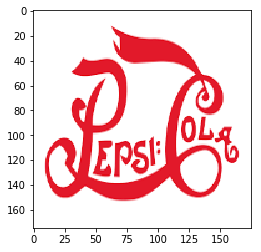

** Showing result images..


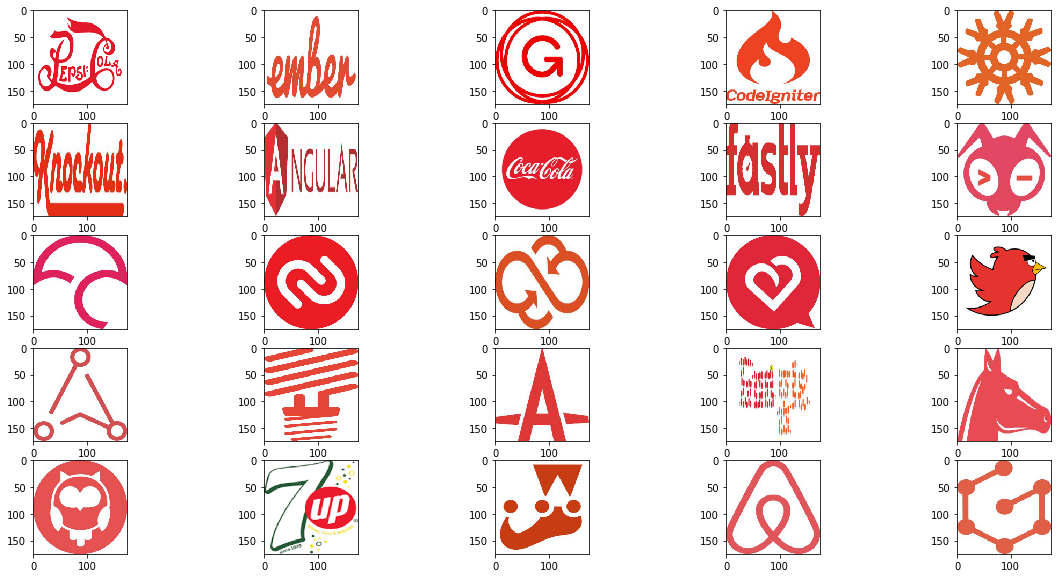


#########################################

>> At image 1 of around 5..
** Input Image - 


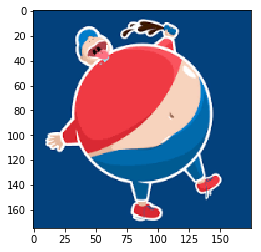

** Showing result images..


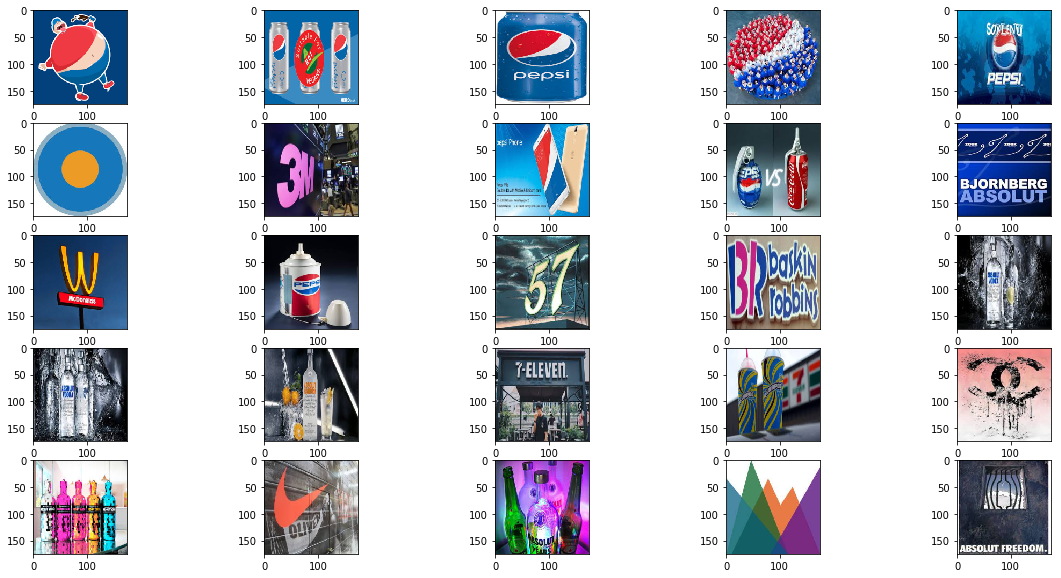


#########################################

>> At image 2 of around 5..
** Input Image - 


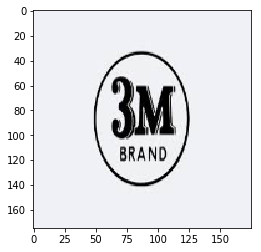

** Showing result images..


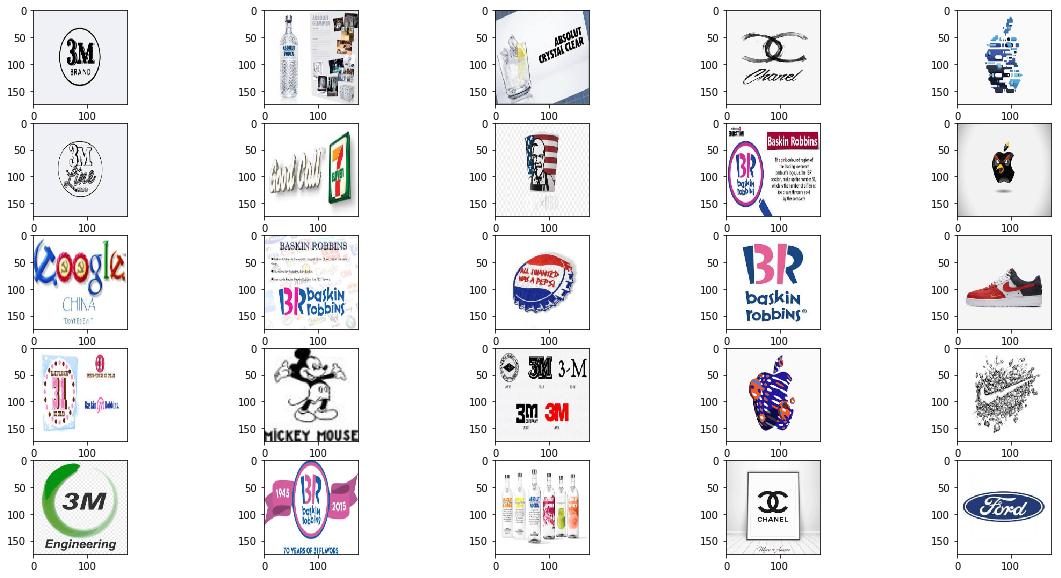


#########################################

>> At image 3 of around 5..
** Input Image - 


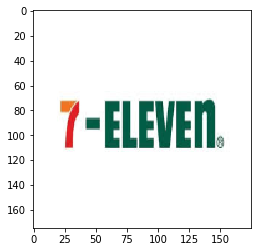

** Showing result images..


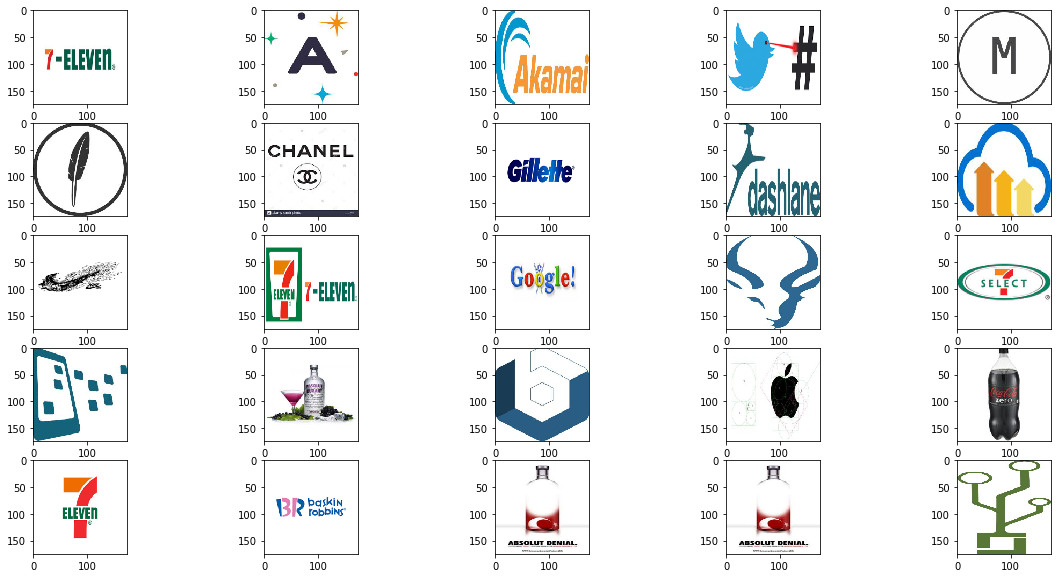


#########################################

>> At image 4 of around 5..
** Input Image - 


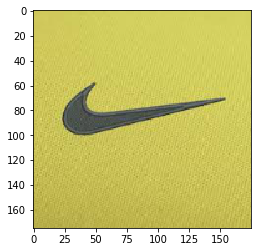

** Showing result images..


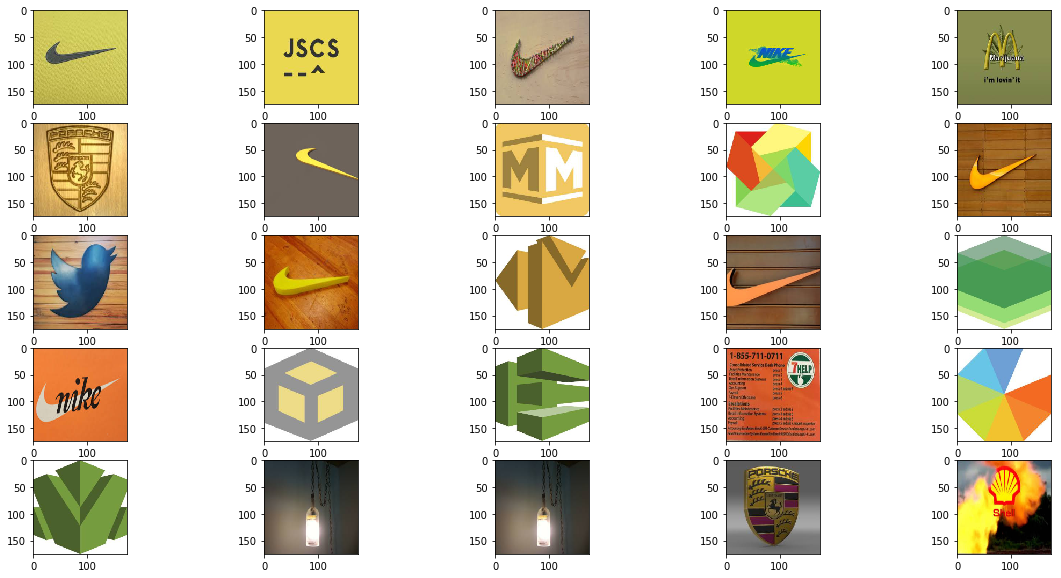


#########################################



In [38]:
# return_similar_images(xin,latents_xin,xrep,latents_xrep,no_suggestions,similarity_check_mode,print_result)

_,_,_ = return_similar_images(x_input,latent_input,x_db,latent_db,25,'cosine_ratio',True)